In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from three_step_classification import ThreeStepClassifier

In [20]:
import IPython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Classification Report Train Set:
              precision    recall  f1-score   support

         agg       1.00      1.00      1.00        10
         oof       1.00      1.00      1.00         6
         plt       1.00      1.00      1.00         7
         rbc       1.00      1.00      1.00        12
         wbc       1.00      1.00      1.00         9

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44


Classification Report Test Set:
              precision    recall  f1-score   support

         agg       0.75      0.90      0.82        10
         oof       0.60      0.60      0.60         5
         plt       0.87      0.81      0.84        16
         rbc       1.00      0.79      0.88        19
         wbc       0.70      0.82      0.76        17

    accuracy                           0.81        67
   macro avg       0.78      0.79      0.78        67
weighted a

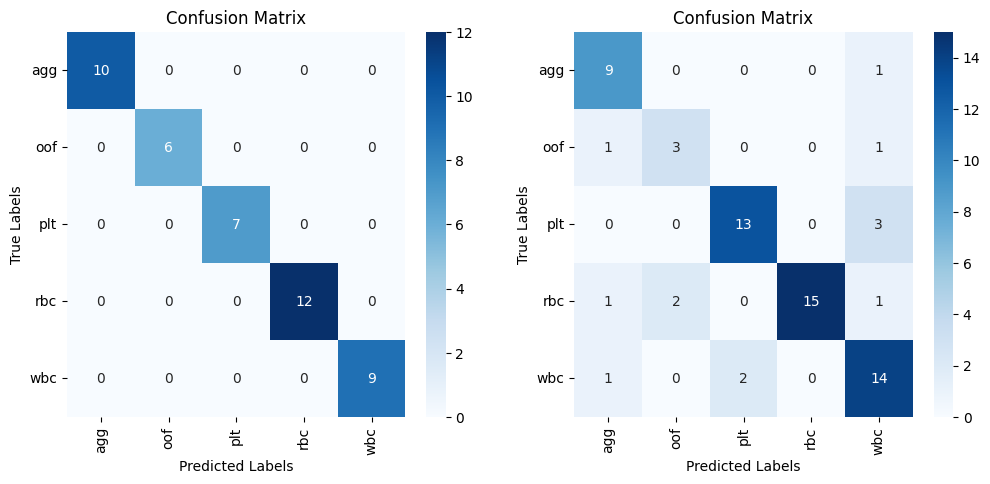

In [121]:
df_labeled = pd.read_csv("labeled_examples.csv")
df_unlabeled = pd.read_csv("unlabeled_sample01_cellpose.csv")

# we remove the centroid displacement features as they're bugged (for now)
del df_labeled['PhaseSTDLocalCentroidDisplacement']
del df_unlabeled['PhaseSTDLocalCentroidDisplacement']
del df_labeled['AmplitudeSTDLocalCentroidDisplacement']
del df_unlabeled['AmplitudeSTDLocalCentroidDisplacement']

df_labeled['Labels'] = df_labeled['Labels'].str.strip("b'")

oof_model = LogisticRegression(class_weight='balanced', random_state=42)
agg_model =  RandomForestClassifier(n_estimators=100, random_state=42)
cell_model =  RandomForestClassifier(n_estimators=100, random_state=42)
tsc = ThreeStepClassifier(oof_model, agg_model, cell_model, num_features_oof=15, num_features_agg=15, num_features_cell=15)

X_train, X_test, y_train, y_test = train_test_split(df_labeled.drop('Labels', axis=1), df_labeled['Labels'], test_size=0.6, random_state=42)
X_train['Labels'] = y_train
tsc.fit(X_train)
df = tsc.predict(df_unlabeled)
y_test_pred = tsc.predict(X_test)['Labels']
y_train_pred = tsc.predict(X_train.drop('Labels', axis=1))['Labels']

df['Labels'].value_counts()

confusion_mtx_train = confusion_matrix(y_train, y_train_pred)
classification_rep_train = classification_report(y_train, y_train_pred)

# Calculate confusion matrix and classification report
confusion_mtx = confusion_matrix(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Print confusion matrix and classification report
print("\nClassification Report Train Set:")
print(classification_rep_train)
print("\nClassification Report Test Set:")
print(classification_rep)


# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx_train, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title('Training Set')
# Plot the confusion matrix heatmap
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title('Test Set')

for i in range(2):
# Set labels, title, and ticks
    axs[i].set_xlabel('Predicted Labels')
    axs[i].set_ylabel('True Labels')
    axs[i].set_title('Confusion Matrix')
    axs[i].xaxis.set_ticklabels(np.unique(y_test), rotation=90)
    axs[i].yaxis.set_ticklabels(np.unique(y_test), rotation=0)

# Show the plot
plt.show()

In [122]:
proba_oof, proba_agg, proba_cell = tsc.predict_proba(X_test)

In [112]:
def plot_points_oof(df_labeled, df_unlabeled, feature1, feature2):
    df_unlabeled_oof = df_unlabeled[df_unlabeled['Labels'] == "oof"]
    df_unlabeled_if = df_unlabeled[df_unlabeled['Labels'] != "oof"]
    df_labeled_oof = df_labeled[df_labeled['Labels'] == "oof"]
    df_labeled_if = df_labeled[df_labeled['Labels'] != "oof"]
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Plot labeled points
    ax.scatter(df_unlabeled_oof[feature1], df_unlabeled_oof[feature2],
               color='red', marker='x', alpha=0.2, label='Unlabeled Out of Focus')
    ax.scatter(df_unlabeled_if[feature1], df_unlabeled_if[feature2],
               color='lightgreen', marker='x', alpha=0.2, label='Unlabeled In Focus')
    
    
    ax.scatter(df_labeled_if[feature1], df_labeled_if[feature2],
               color='darkgreen', label='Labeled In Focus')
    ax.scatter(df_labeled_oof[feature1], df_labeled_oof[feature2],
               color='darkred', label='Labeled Out of Focus')
    # Plot unlabeled points
    # Set plot title and labels
    ax.set_title('Scatter Plot')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [125]:
tsc.selected_features_oof

['Opacity',
 'AmplitudeSTDLocalMean',
 'AmplitudeSTDLocalMin',
 'OpacityRangewbc',
 'OpacityRangeplt',
 'OpacityRangeagg',
 'OpacityRangerbc',
 'AmplitudeSTDLocalMeanRangewbc',
 'AmplitudeSTDLocalMeanRangeplt',
 'AmplitudeSTDLocalMeanRangeagg',
 'AmplitudeSTDLocalMeanRangerbc',
 'AmplitudeSTDLocalMinRangewbc',
 'AmplitudeSTDLocalMinRangeplt',
 'AmplitudeSTDLocalMinRangeagg',
 'AmplitudeSTDLocalMinRangerbc']

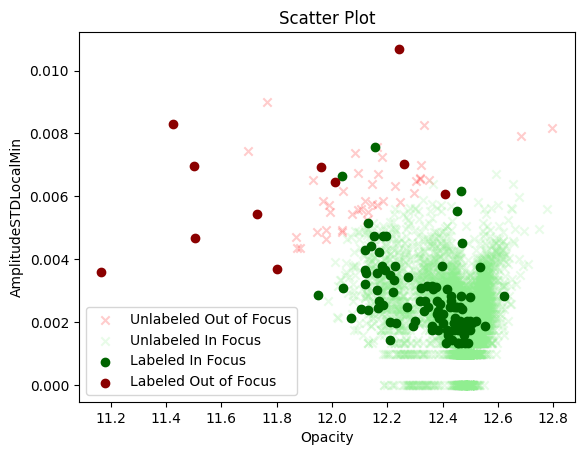

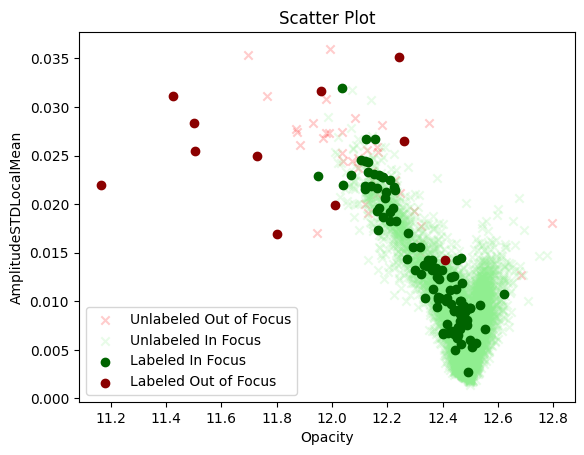

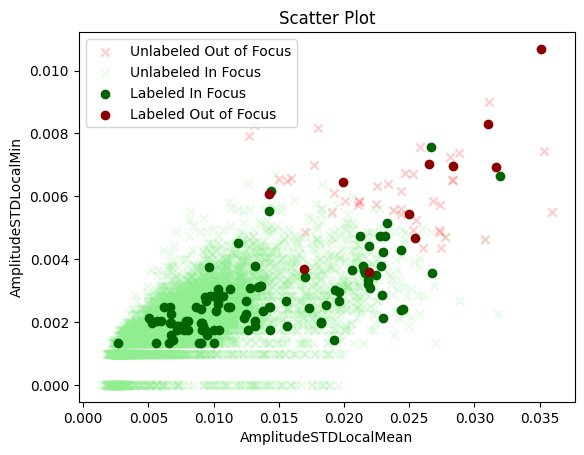

In [126]:
plot_points_oof(df_labeled, df, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_oof(df_labeled, df, 'Opacity', 'AmplitudeSTDLocalMean')
plot_points_oof(df_labeled, df, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMin')

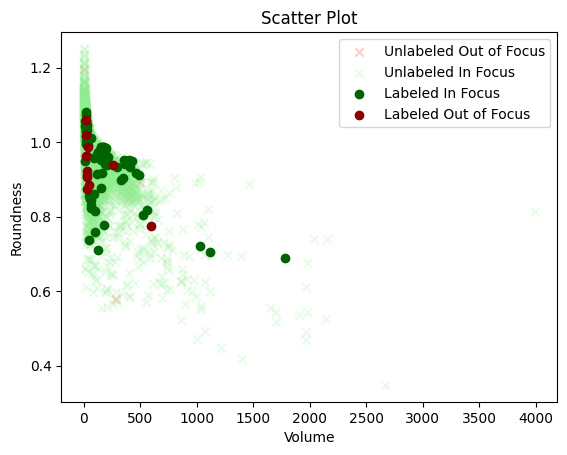

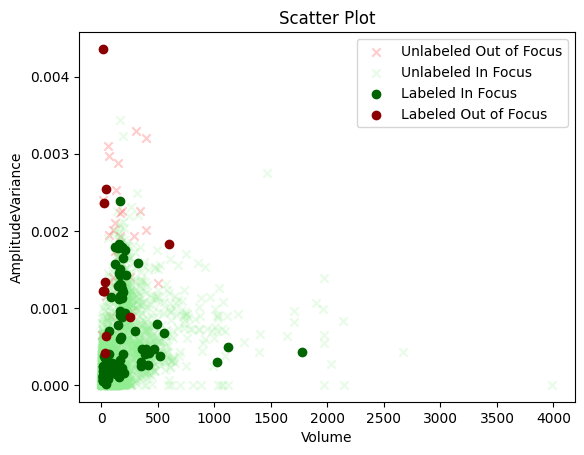

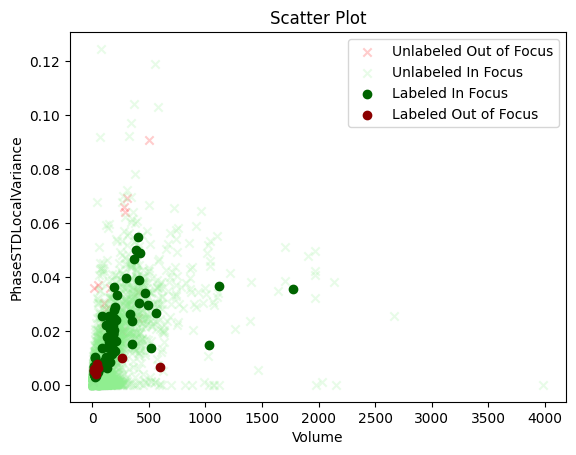

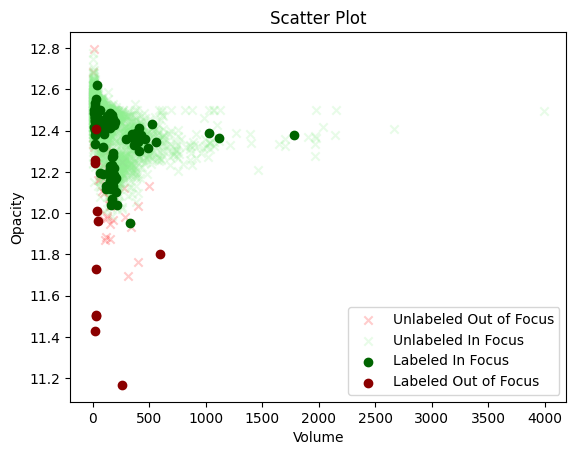

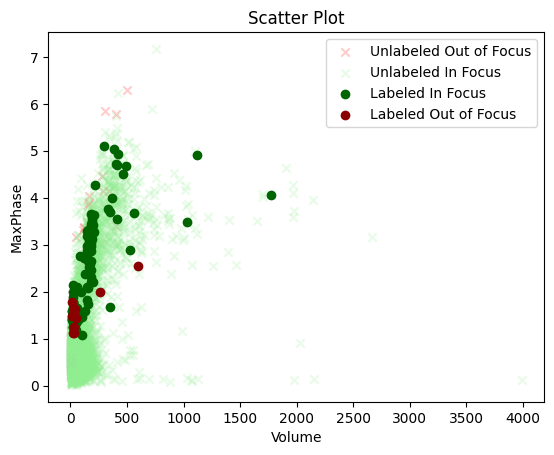

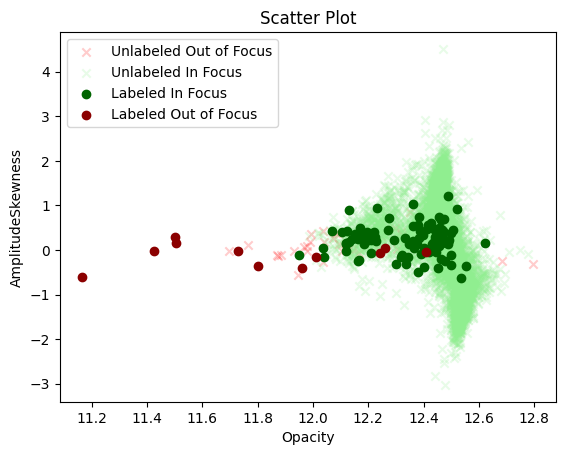

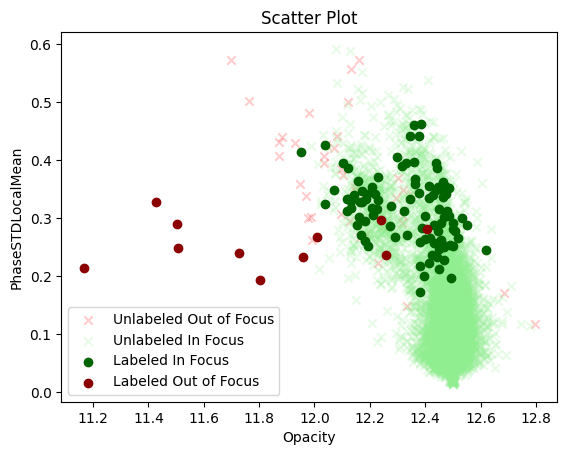

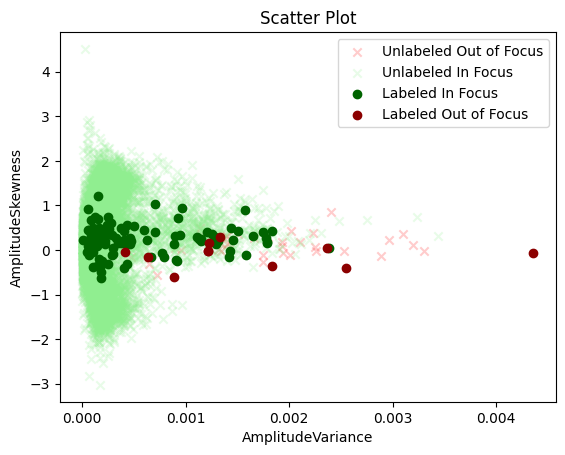

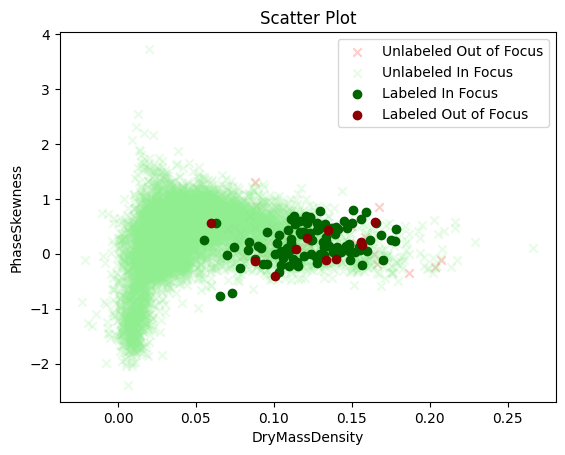

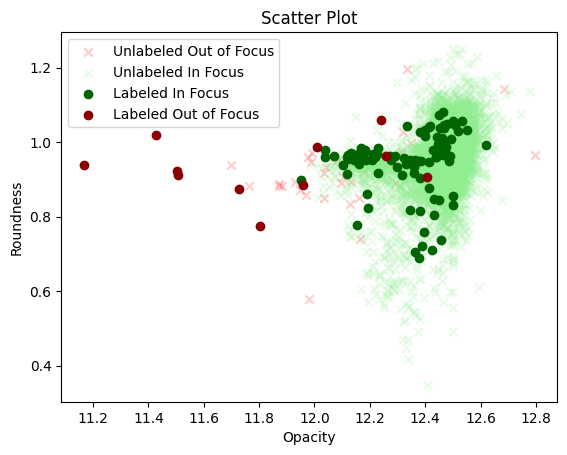

In [127]:
plot_points_oof(df_labeled, df, 'Volume', 'Roundness')
plot_points_oof(df_labeled, df, 'Volume', 'AmplitudeVariance')
plot_points_oof(df_labeled, df, 'Volume', 'PhaseSTDLocalVariance')
plot_points_oof(df_labeled, df, 'Volume', 'Opacity')
plot_points_oof(df_labeled, df, 'Volume', 'MaxPhase')
plot_points_oof(df_labeled, df, 'Opacity', 'AmplitudeSkewness')
plot_points_oof(df_labeled, df, 'Opacity', 'PhaseSTDLocalMean')
plot_points_oof(df_labeled, df, 'AmplitudeVariance', 'AmplitudeSkewness')
plot_points_oof(df_labeled, df, 'DryMassDensity', 'PhaseSkewness')
plot_points_oof(df_labeled, df, 'Opacity', 'Roundness')

In [80]:
def plot_points_agg(df_labeled, df_unlabeled, feature1, feature2):
    df_unlabeled_oof = df_unlabeled[df_unlabeled['Labels'] == "agg"]
    df_unlabeled_if = df_unlabeled[(df_unlabeled['Labels'] != "agg") & (df_unlabeled['Labels'] != "oof")]
    df_labeled_oof = df_labeled[df_labeled['Labels'] == "agg"]
    df_labeled_if = df_labeled[(df_labeled['Labels'] != "agg") & (df_labeled['Labels'] != "oof")]
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Plot labeled points
    ax.scatter(df_unlabeled_oof[feature1], df_unlabeled_oof[feature2],
               color='red', marker='x', alpha=0.2, label='Unlabeled Aggregated')
    ax.scatter(df_unlabeled_if[feature1], df_unlabeled_if[feature2],
               color='lightgreen', marker='x', alpha=0.2, label='Unlabeled Single Cell')
    
    
    ax.scatter(df_labeled_if[feature1], df_labeled_if[feature2],
               color='darkgreen', label='Labeled Single Cell')
    ax.scatter(df_labeled_oof[feature1], df_labeled_oof[feature2],
               color='darkred', label='Labeled Aggregated')
    # Plot unlabeled points
    # Set plot title and labels
    ax.set_title('Scatter Plot')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [128]:
tsc.selected_features_agg

['Roundness',
 'AmplitudeSkewness',
 'DryMassDensity',
 'RoundnessRangewbc',
 'RoundnessRangeplt',
 'RoundnessRangerbc',
 'AmplitudeSkewnessRangewbc',
 'AmplitudeSkewnessRangeplt',
 'AmplitudeSkewnessRangerbc',
 'DryMassDensityRangewbc',
 'DryMassDensityRangeplt',
 'DryMassDensityRangerbc',
 'AmplitudeSTDLocalVarianceRangewbc',
 'AmplitudeSTDLocalVarianceRangeplt',
 'AmplitudeSTDLocalVarianceRangerbc']

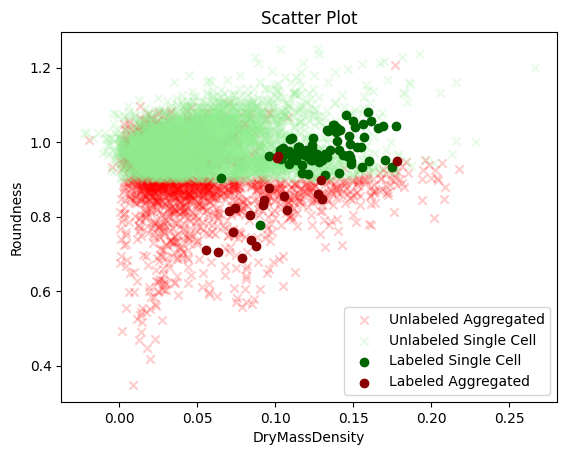

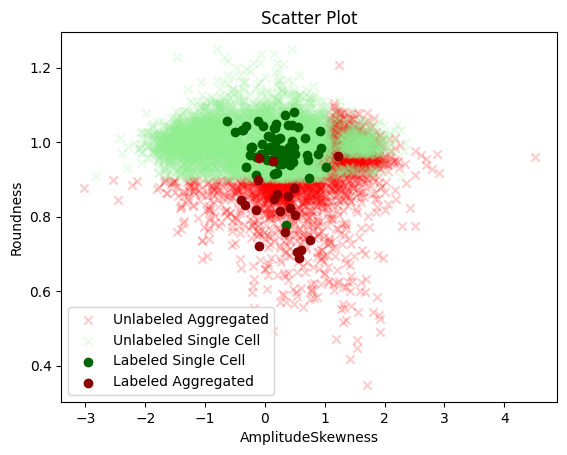

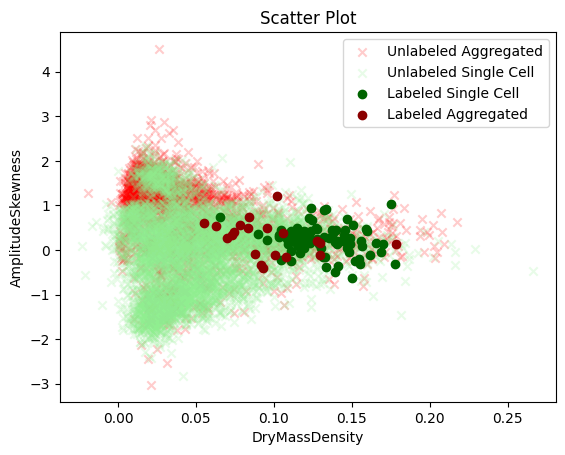

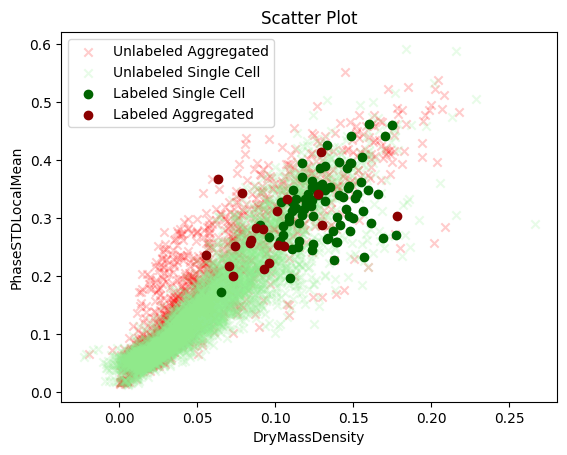

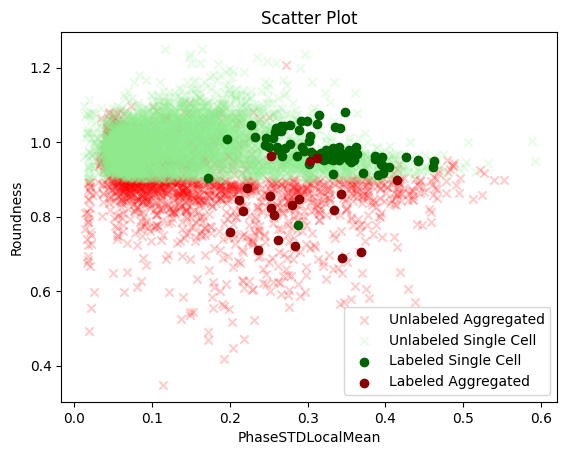

In [130]:
plot_points_agg(df_labeled, df, 'DryMassDensity', 'Roundness')
plot_points_agg(df_labeled, df, 'AmplitudeSkewness', 'Roundness')
plot_points_agg(df_labeled, df, 'DryMassDensity', 'AmplitudeSkewness')
plot_points_agg(df_labeled, df, 'DryMassDensity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df, 'PhaseSTDLocalMean', 'Roundness')

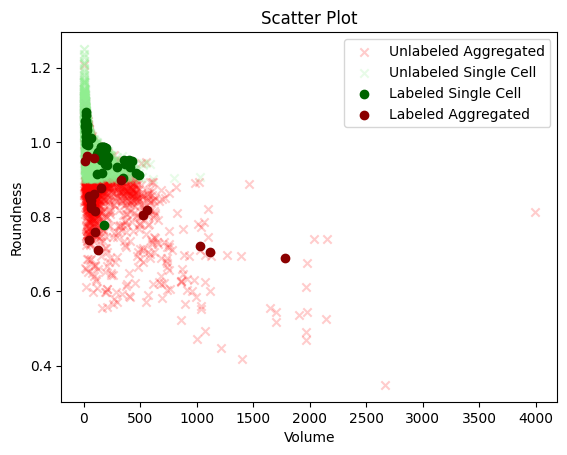

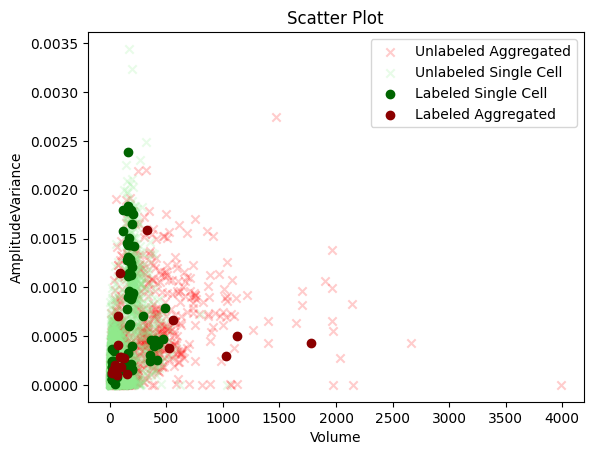

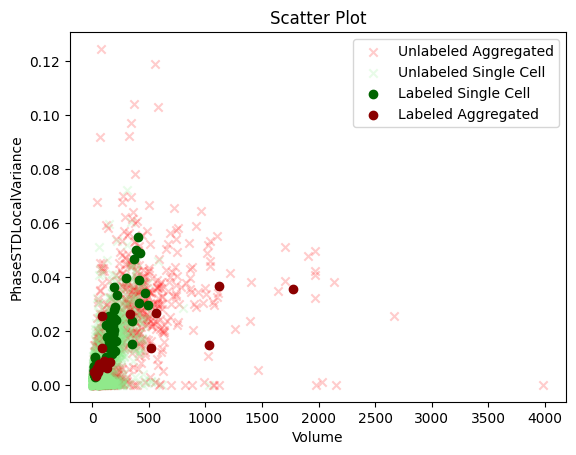

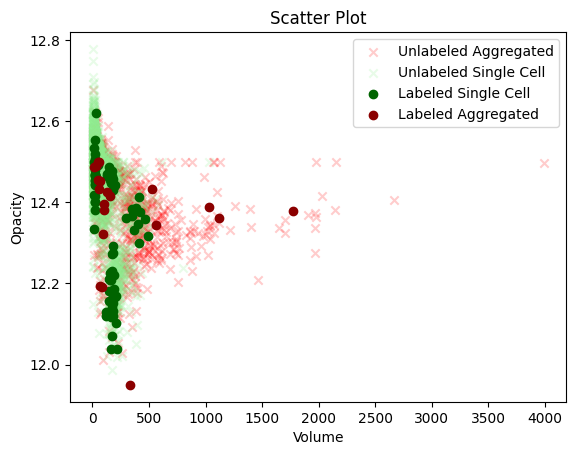

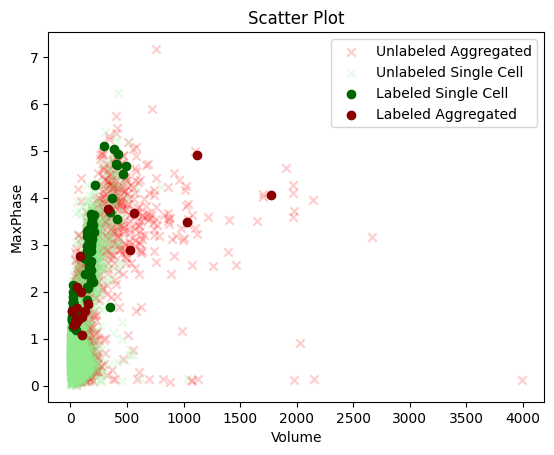

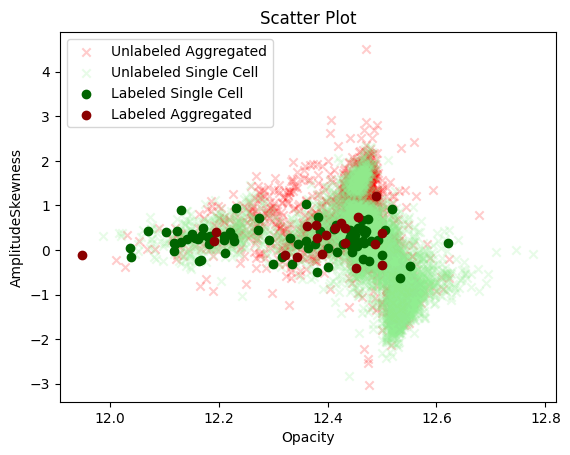

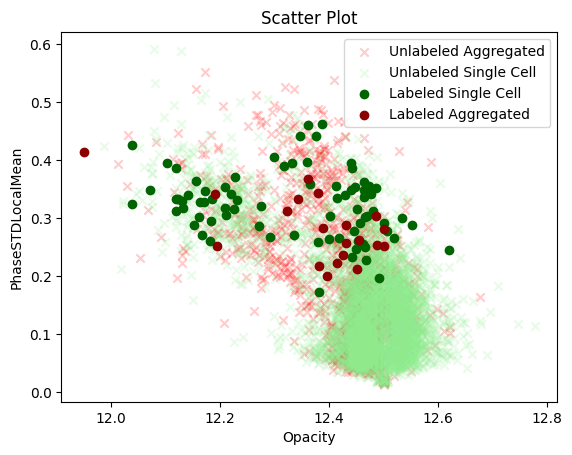

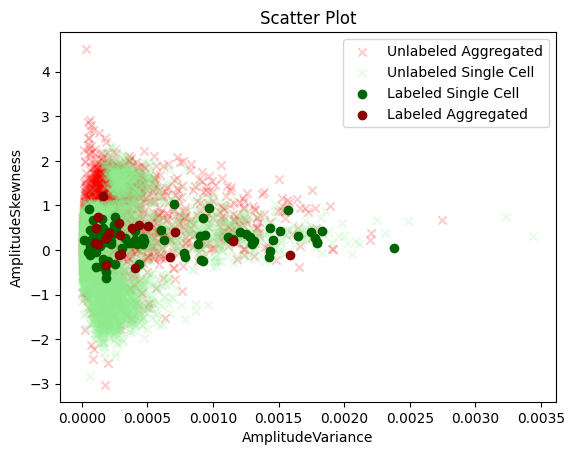

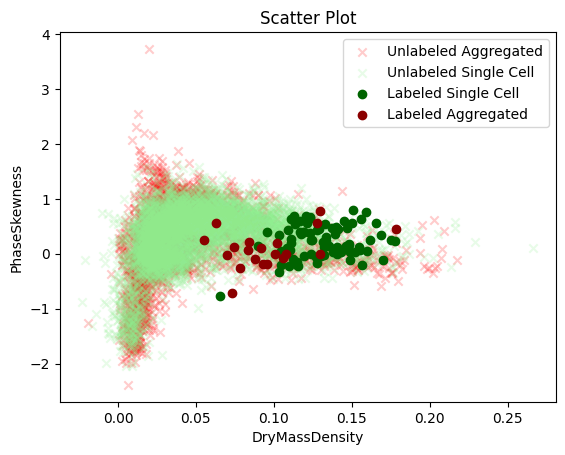

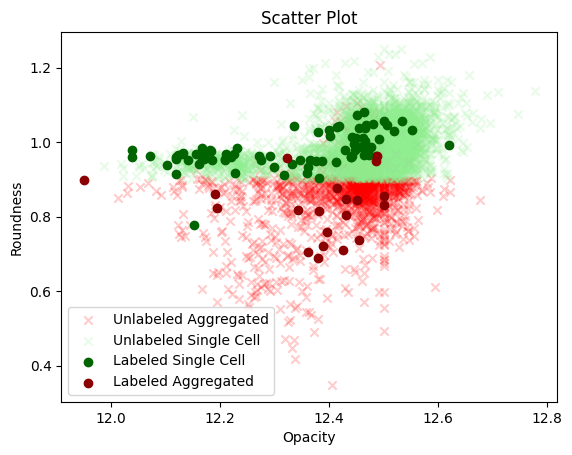

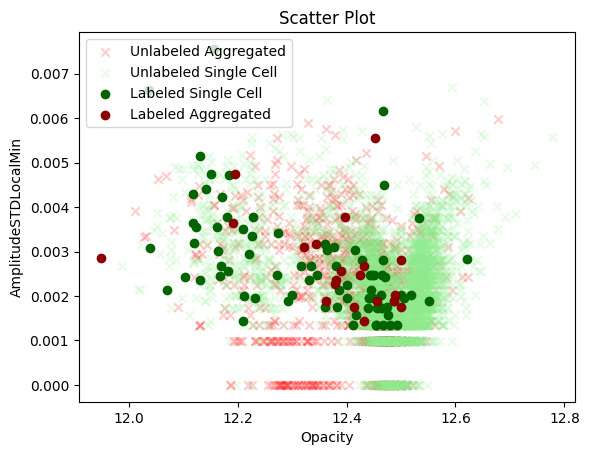

In [131]:
plot_points_agg(df_labeled, df, 'Volume', 'Roundness')
plot_points_agg(df_labeled, df, 'Volume', 'AmplitudeVariance')
plot_points_agg(df_labeled, df, 'Volume', 'PhaseSTDLocalVariance')
plot_points_agg(df_labeled, df, 'Volume', 'Opacity')
plot_points_agg(df_labeled, df, 'Volume', 'MaxPhase')
plot_points_agg(df_labeled, df, 'Opacity', 'AmplitudeSkewness')
plot_points_agg(df_labeled, df, 'Opacity', 'PhaseSTDLocalMean')
plot_points_agg(df_labeled, df, 'AmplitudeVariance', 'AmplitudeSkewness')
plot_points_agg(df_labeled, df, 'DryMassDensity', 'PhaseSkewness')
plot_points_agg(df_labeled, df, 'Opacity', 'Roundness')
plot_points_agg(df_labeled, df, 'Opacity', 'AmplitudeSTDLocalMin')

In [85]:
def plot_points_cells(df_labeled, df_unlabeled, feature1, feature2):
    df_unlabeled_wbc = df_unlabeled[df_unlabeled['Labels'] == "wbc"]
    df_unlabeled_rbc = df_unlabeled[df_unlabeled['Labels'] == "rbc"]
    df_unlabeled_plt = df_unlabeled[df_unlabeled['Labels'] == "plt"]
    df_labeled_wbc = df_labeled[df_labeled['Labels'] == "wbc"]
    df_labeled_rbc = df_labeled[df_labeled['Labels'] == "rbc"]
    df_labeled_plt = df_labeled[df_labeled['Labels'] == "plt"]
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Plot labeled points
    ax.scatter(df_unlabeled_wbc[feature1], df_unlabeled_wbc[feature2],
               color='red', marker='x', alpha=0.2, label='Unlabeled WBC')
    ax.scatter(df_unlabeled_rbc[feature1], df_unlabeled_rbc[feature2],
               color='lightgreen', marker='x', alpha=0.2, label='Unlabeled RBC')
    ax.scatter(df_unlabeled_plt[feature1], df_unlabeled_plt[feature2],
               color='lightblue', marker='x', alpha=0.2, label='Unlabeled PLT')
    
    
    ax.scatter(df_labeled_wbc[feature1], df_labeled_wbc[feature2],
               color='darkred', label='Labeled WBC')
    ax.scatter(df_labeled_rbc[feature1], df_labeled_rbc[feature2],
               color='darkgreen', label='Labeled RBC')
    ax.scatter(df_labeled_plt[feature1], df_labeled_plt[feature2],
               color='darkblue', label='Labeled PLT')
    # Plot unlabeled points
    # Set plot title and labels
    ax.set_title('Scatter Plot')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [132]:
tsc.selected_features_cell

['Opacity',
 'MaxAmplitude',
 'AmplitudeSTDLocalMean',
 'AmplitudeSTDLocalMax',
 'OpacityRangewbc',
 'OpacityRangerbc',
 'MaxAmplitudeRangewbc',
 'MaxAmplitudeRangeplt',
 'MaxAmplitudeRangerbc',
 'AmplitudeSTDLocalMeanRangewbc',
 'AmplitudeSTDLocalMeanRangeplt',
 'AmplitudeSTDLocalMeanRangerbc',
 'AmplitudeSTDLocalMaxRangewbc',
 'AmplitudeSTDLocalMaxRangeplt',
 'AmplitudeSTDLocalMaxRangerbc']

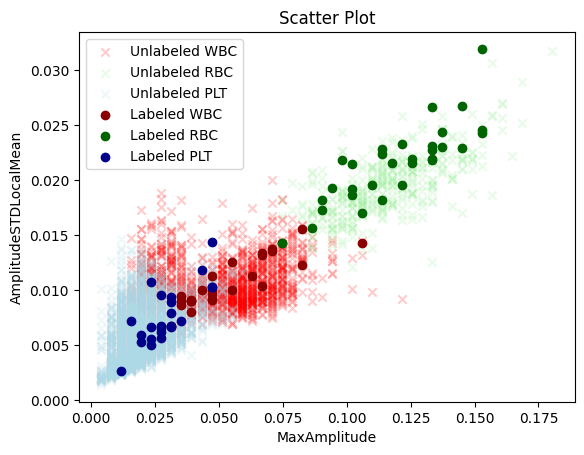

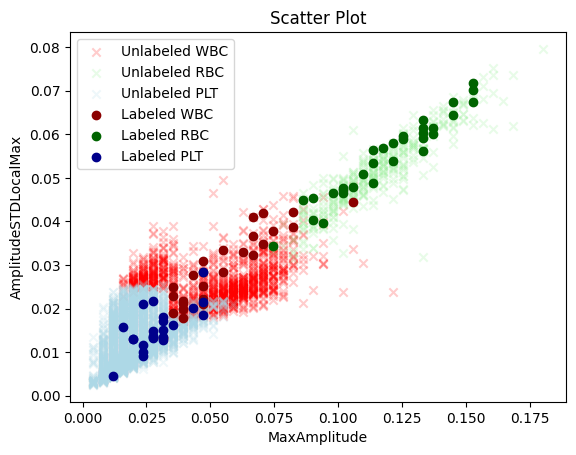

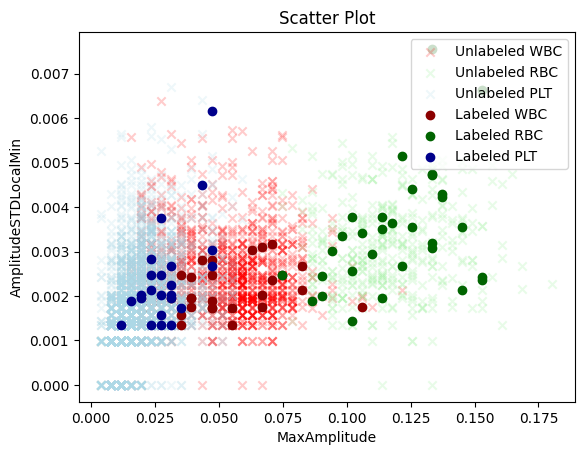

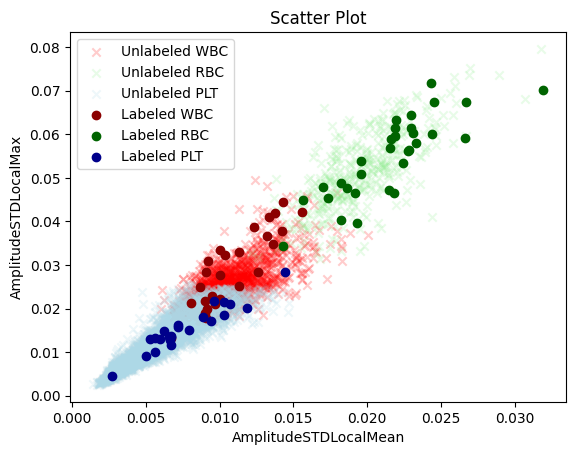

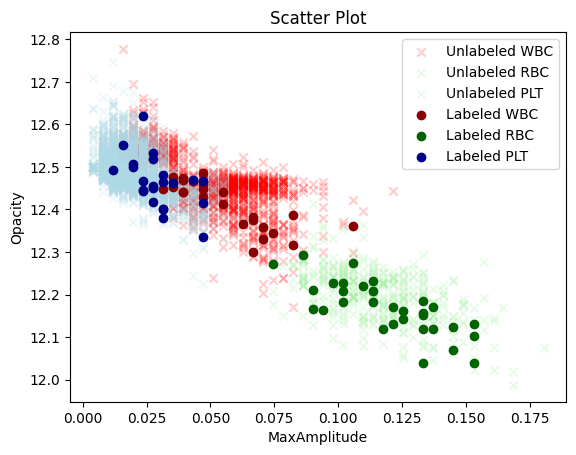

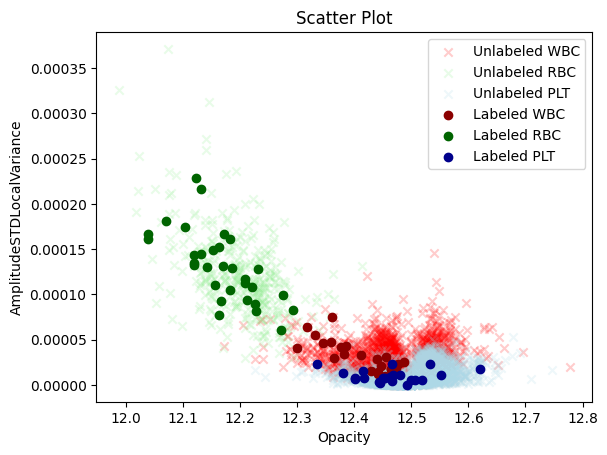

In [133]:
plot_points_cells(df_labeled, df, 'MaxAmplitude', 'AmplitudeSTDLocalMean')
plot_points_cells(df_labeled, df, 'MaxAmplitude', 'AmplitudeSTDLocalMax')
plot_points_cells(df_labeled, df, 'MaxAmplitude', 'AmplitudeSTDLocalMin')
plot_points_cells(df_labeled, df, 'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalMax')
plot_points_cells(df_labeled, df, 'MaxAmplitude', 'Opacity')
plot_points_cells(df_labeled, df, 'Opacity', 'AmplitudeSTDLocalVariance')

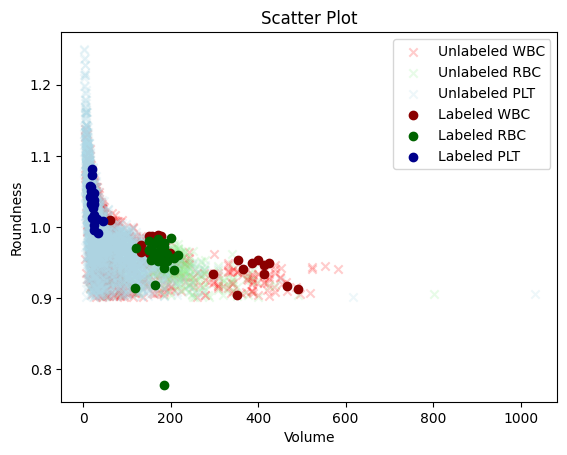

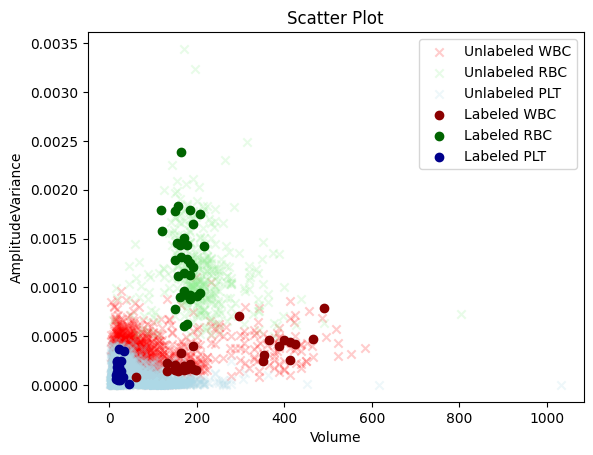

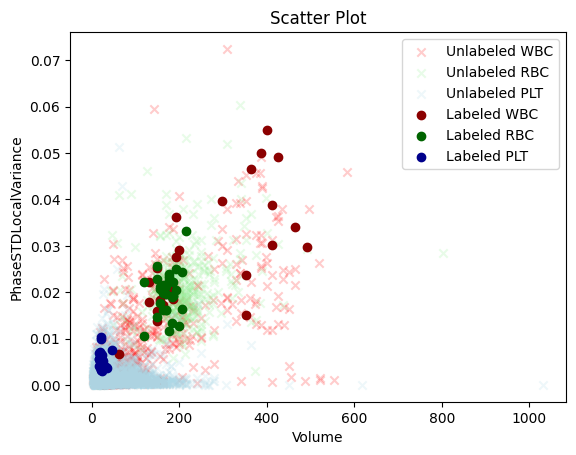

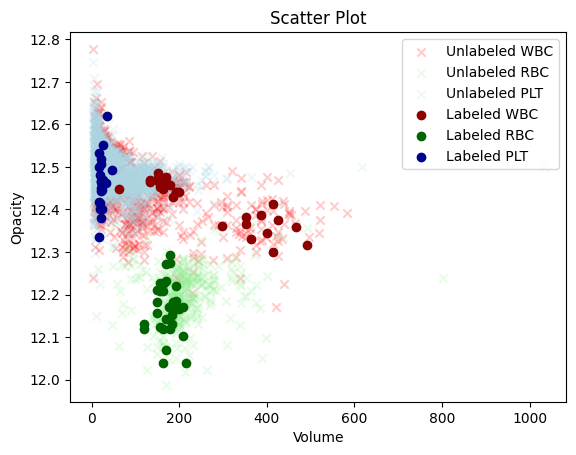

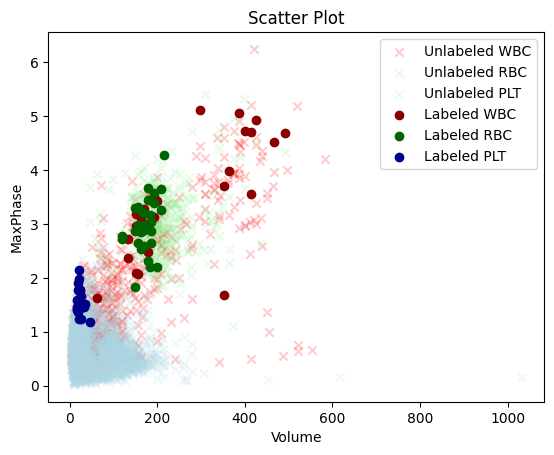

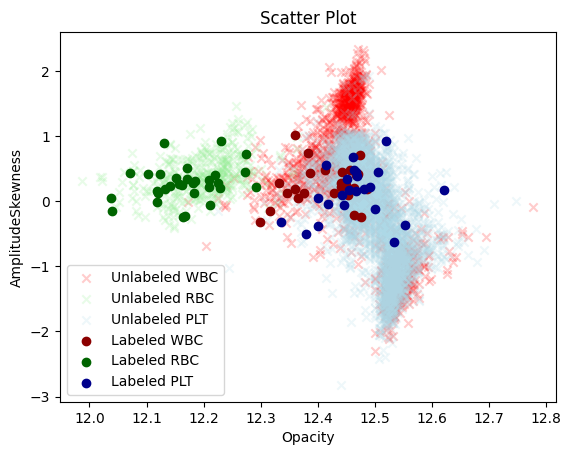

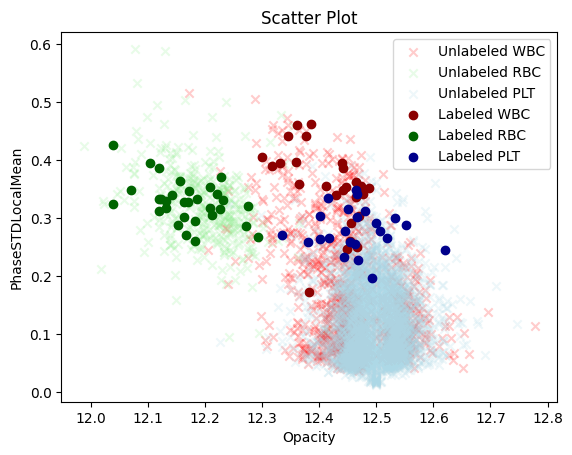

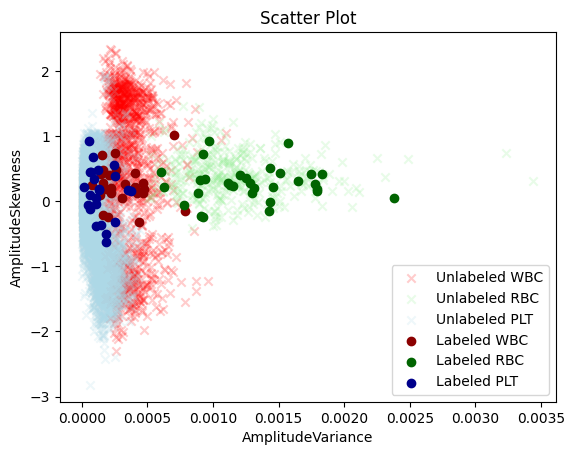

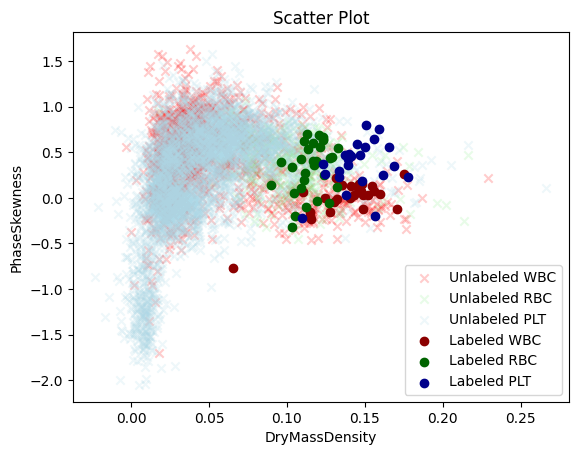

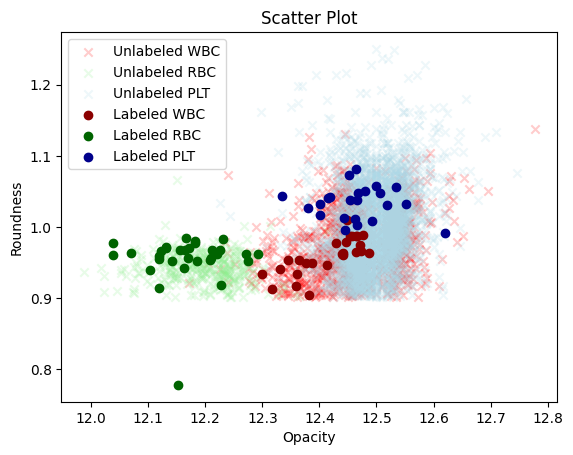

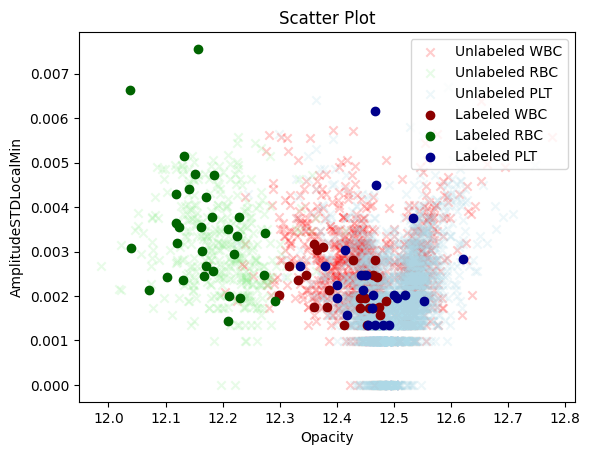

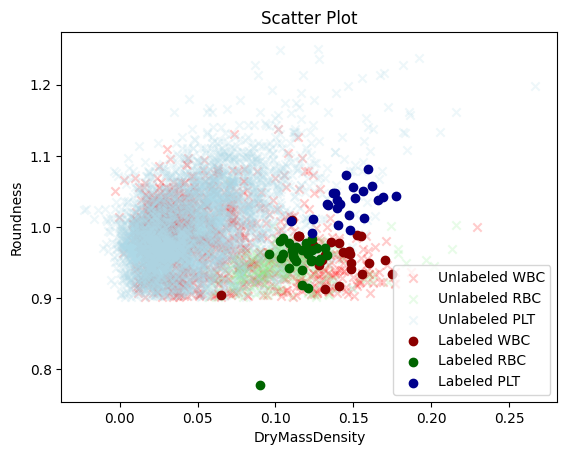

In [134]:
plot_points_cells(df_labeled, df, 'Volume', 'Roundness')
plot_points_cells(df_labeled, df, 'Volume', 'AmplitudeVariance')
plot_points_cells(df_labeled, df, 'Volume', 'PhaseSTDLocalVariance')
plot_points_cells(df_labeled, df, 'Volume', 'Opacity')
plot_points_cells(df_labeled, df, 'Volume', 'MaxPhase')
plot_points_cells(df_labeled, df, 'Opacity', 'AmplitudeSkewness')
plot_points_cells(df_labeled, df, 'Opacity', 'PhaseSTDLocalMean')
plot_points_cells(df_labeled, df, 'AmplitudeVariance', 'AmplitudeSkewness')
plot_points_cells(df_labeled, df, 'DryMassDensity', 'PhaseSkewness')
plot_points_cells(df_labeled, df, 'Opacity', 'Roundness')
plot_points_cells(df_labeled, df, 'Opacity', 'AmplitudeSTDLocalMin')
plot_points_cells(df_labeled, df, 'DryMassDensity', 'Roundness')